In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import seaborn as sns
sns.set_context('notebook')
import matplotlib.pyplot as plt
%matplotlib inline

Define functions which will be used for training, tuning, and evaluating models.

In [2]:
# Train a baseline random forest model
def train_rfc(X, y, params = {'n_estimators' : 100, 
                              'random_state' : 42,
                              'n_jobs' : -1}):
    """
    Helper function to train a baseline random forest classifier.
    """
    rfc = RandomForestClassifier(**params)
    rfc.fit(X, y)
    return rfc

In [3]:
# Hyperparameter tuning techniques 
def get_grid_search_best_params(X, y, model, params, scoring_metric = 'f1', cv = 5):
    """
    Runs grid search on specified parameters and returns parameter set with highest score.
    """
    grid_search = GridSearchCV(model, param_grid = params, scoring = scoring_metric, cv = cv)
    grid_search.fit(X, y)
    return grid_search.best_params_  

def get_random_search_best_params(X, y, model, params, scoring_metric = 'f1', cv = 5, n_iter_search = 20):
    """
    Runs random search on specified parameters and returns parameter set with highest score.
    """
    random_search = RandomizedSearchCV(model, param_distributions = params, scoring = scoring_metric, 
                                       n_iter = n_iter_search, cv = cv)
    random_search.fit(X, y)
    return random_search.best_params_ 

In [4]:
# Evaluate model results
def model_performance_report(model, X, y):
    """
    Gets model performance metrics, like precision, recall, f1 score, accuracy score.
    """
    y_pred = model.predict(X)
    print(classification_report(y, y_pred))
    print('accuracy score:', accuracy_score(y, y_pred))
    
def plot_feature_importances(model, feature_names, top_n = 10):
    """
    Plots top N features in order of importance scores decided by the model.
    """
    feat_importances = sorted(zip(feature_names, abs(model.feature_importances_)), key = lambda x: -x[1])[:top_n]
    frame_size = top_n // 2
    plt.figure(figsize = (frame_size, frame_size))
    features_, scores_ = zip(*feat_importances)
    sns.barplot(y = list(features_), x = list(scores_), palette = 'pastel')
    plt.title('feature relative importances', fontsize = 14)
    plt.xlabel('feature importance scores', fontsize = 12)
    plt.ylabel('features', fontsize = 12);

In [5]:
df = pd.read_csv('us_income_data.csv')

In [6]:
# Prepare train, validation, and test sets
target_var = 'income'

X, y = df.drop(target_var, axis=1), df[target_var]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.3, random_state = 42)

Now we can train the data and tune hyperparameters. For this assignment, I chose random forest for my mode. Since the data has many categorical features which are turned into a sparse matrix of dummies, I think it makes sense to approach it with a tree-based model which will perform binary splits and also handle numerical features without scaling them.

Here, I will train a baseline random forest classifier, optimize it with GridSearch and RandomizedSearch, and compare results.

In [7]:
# Train baseline random forest binary classifier
%time baseline_rfc = train_rfc(X_train, y_train)

CPU times: user 1.59 s, sys: 43.4 ms, total: 1.63 s
Wall time: 598 ms


In [8]:
# Generate parameters for random and grid search
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 1000, num = 8)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 30, num = 6)]
max_depth.append(None)
min_samples_leaf = [1, 2, 5, 10]
bootstrap = [True, False]
class_weight = ['balanced', None]

In [9]:
# Define random grid parameters.
random_search_params = {'n_estimators' : n_estimators,
                        'max_features' : max_features,
                        'max_depth' : max_depth,
                        'min_samples_leaf' : min_samples_leaf,
                        'bootstrap' : bootstrap,
                        'class_weight' : class_weight}

In [10]:
# Run random search on baseline classifier and get best scoring parameters.
%time random_search_best_params = get_random_search_best_params(X_train, y_train, baseline_rfc, random_search_params)

CPU times: user 15min 12s, sys: 27.5 s, total: 15min 40s
Wall time: 5min 39s


In [11]:
# Define grid search parameters
grid_search_params = {'n_estimators' : [100, 150, 200],
                      'max_features' : max_features,
                      'max_depth' : [15, 25],
                      'min_samples_leaf' : [2, 5, 8],
                      'bootstrap' : bootstrap,
                      'class_weight' : ['balanced', None]}

In [12]:
%time grid_search_best_params = get_grid_search_best_params(X_train, y_train, baseline_rfc, grid_search_params)

CPU times: user 25min 37s, sys: 41.9 s, total: 26min 19s
Wall time: 10min 58s


Now train two more models with the best parameters from GridSearch and RandomizedSearch.

In [13]:
%time rfc_grid_search_params = train_rfc(X_train, y_train, grid_search_best_params)

CPU times: user 1.56 s, sys: 10.2 ms, total: 1.57 s
Wall time: 1.58 s


In [14]:
%time rfc_random_search_params = train_rfc(X_train, y_train, random_search_best_params)

CPU times: user 6.87 s, sys: 76.9 ms, total: 6.94 s
Wall time: 7.06 s


### Testing on validation set

Performance report for baseline random forest classifier.

             precision    recall  f1-score   support

          0       0.87      0.92      0.90      4095
          1       0.72      0.61      0.66      1379

avg / total       0.84      0.84      0.84      5474

accuracy score: 0.842345633906


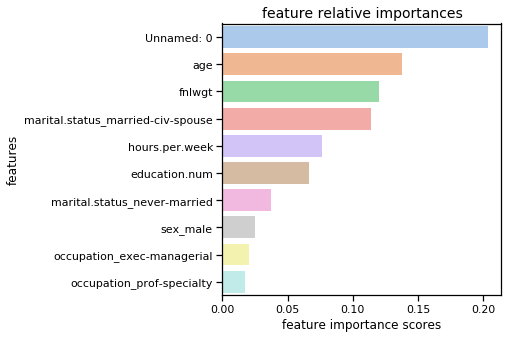

In [15]:
print("Performance report for baseline random forest classifier.")
print()
model_performance_report(baseline_rfc, X_val, y_val)
plot_feature_importances(baseline_rfc, X_train.columns.values)

Performance report for random forest classifier with grid search best parameters.

             precision    recall  f1-score   support

          0       0.91      0.86      0.89      4095
          1       0.64      0.76      0.70      1379

avg / total       0.85      0.83      0.84      5474

accuracy score: 0.833942272561


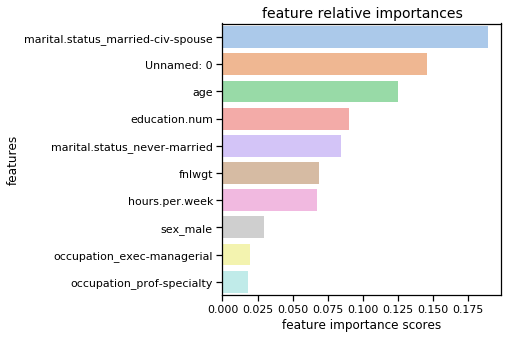

In [16]:
print("Performance report for random forest classifier with grid search best parameters.")
print()
model_performance_report(rfc_grid_search_params, X_val, y_val)
plot_feature_importances(rfc_grid_search_params, X_train.columns.values)

Performance report for random forest classifier with random search best parameters.

             precision    recall  f1-score   support

          0       0.91      0.86      0.89      4095
          1       0.65      0.76      0.70      1379

avg / total       0.85      0.84      0.84      5474

accuracy score: 0.837595907928


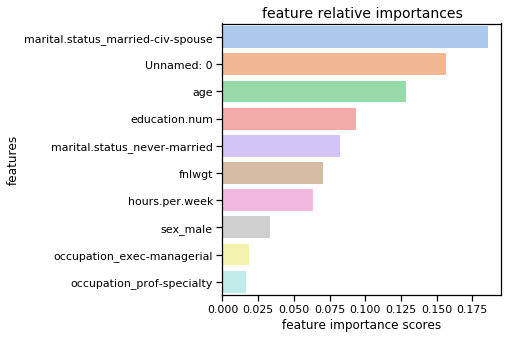

In [17]:
print("Performance report for random forest classifier with random search best parameters.")
print()
model_performance_report(rfc_random_search_params, X_val, y_val)
plot_feature_importances(rfc_random_search_params, X_train.columns.values)

The baseline model has worse precision for the majority class but better precision for the minority class, and models whose parameters were tuned with GridSearch and RandomizedSearch perform slightly better in terms of f1 score for both classes. Since f1 score was the evaluation metric, I am going to choose the model whose parameters were tuned with GridSearch because it has the highest f1 score of them all.

### Model performance on test data

Now let's see how the model of choice performs on unseen data.

In [18]:
print("Performance report for model of choice: baseline random forest classifier.")
print()
model_performance_report(rfc_grid_search_params, X_test, y_test)

Performance report for model of choice: baseline random forest classifier.

             precision    recall  f1-score   support

          0       0.91      0.86      0.89      9138
          1       0.65      0.75      0.70      3026

avg / total       0.85      0.84      0.84     12164

accuracy score: 0.837142387373
